## Goal
1. Link to dwh (data warehouse)
2. Find tables and views
3. Query using combinations of sql and python
4. Create functions to make queries less cumbersome
5. Merge various data sources
6. Run more complicated queries
7. Import .csv files and perform basic statistics

### Import/Write to Oracle

In [1]:
import cx_Oracle
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

os.environ["ORACLE_HOME"] = "/u01/app/oracle/product/19.3.0_client" 
connection = cx_Oracle.connect("DWH_PYTHON_NL/Mzuu6nIE@nlrtd01ora010.nl.glencore.com/nldwa02.nl.glencore.com")
# connection.close()

### Show all tables

In [2]:
cursor = connection.cursor()
dt1 = cursor.execute("""
            SELECT owner, table_name
            FROM all_tables 
        """)
df = pd.DataFrame(dt1)
df.sort_values(1, inplace=True)
cursor.close()

df.columns = ["owner", "tableName"]
#df[df["owner"] == "DWH_DMT_NL"]
df.head(3)

,owner,tableName
6,SYS,ALL_UNIFIED_AUDIT_ACTIONS
5,SYS,AUDIT_ACTIONS
50,SYS,AV_DUAL


### Show all views

In [3]:
cursor = connection.cursor()
dt1 = cursor.execute("""
            SELECT view_name
            FROM all_views
        """)
df = pd.DataFrame(dt1)
df.head(3)

,0
0,ALL_XML_SCHEMAS
1,ALL_XML_SCHEMAS2
2,V_$ADVISOR_CURRENT_SQLPLAN


### Try simple query using BETWEEN dates

In [4]:
cursor = connection.cursor()
dt1 = cursor.execute("""
                 select TRADE_DATE, MARKET_PRICE
                 from Dst_v_Market_Price_Drv
                 where RIC_CODE = 'SX0'
                 AND TRADE_DATE BETWEEN TO_DATE('2020-08-15','YYYY-MM-DD') AND TO_DATE('2020-09-18', 'YYYY-MM-DD')
                """)
df = pd.DataFrame(dt1)
df.columns = [column[0] for column in cursor.description]
df.head()

,TRADE_DATE,MARKET_PRICE
0,2020-08-25,9.2025
1,2020-08-27,9.4200
2,2020-08-19,9.1400
3,2020-08-24,9.0575
4,2020-08-17,9.1525


### Create Python function to run BETWEEN query

In [5]:
def test1(a1, b1):
    SQL = """SELECT TRADE_DATE, MARKET_PRICE, RIC_CODE, TRADE_YEAR 
             FROM Dst_v_Market_Price_Drv 
             WHERE RIC_CODE = 'SX0'
             OR RIC_CODE = 'SF1'
             AND TRADE_DATE BETWEEN TO_DATE(:date1,'YYYY-MM-DD') AND TO_DATE(:date2, 'YYYY-MM-DD')"""
    dt1 = cursor.execute(SQL, {'date1' :  a1, 'date2': b1}).fetchall()
    df1 = pd.DataFrame(dt1)
    df1.columns = [column[0] for column in cursor.description]
    return(df1.sort_values('RIC_CODE'))    

#### Run above query

In [6]:
a1  = '2020-08-15'
b1  = '2020-09-15'
year1 = '2020'
test1(a1, b1).head()

,TRADE_DATE,MARKET_PRICE,RIC_CODE,TRADE_YEAR
1415,2020-08-26,9.3025,SF1,2020
1418,2020-08-17,9.2100,SF1,2020
1417,2020-08-28,9.5625,SF1,2020
1448,2020-09-03,9.7225,SF1,2020
1425,2020-08-18,9.1975,SF1,2020


### Try merging two Ric_Codes



In [7]:
def mergeRics(ric1, ric2, date1, date2):
    SQL = """SELECT TRADE_DATE, MARKET_PRICE, RIC_CODE, TRADE_YEAR 
             FROM Dst_v_Market_Price_Drv 
             WHERE RIC_CODE = :Ric1
             OR RIC_CODE = :Ric2
             AND TRADE_DATE BETWEEN TO_DATE(:date1,'YYYY-MM-DD') AND TO_DATE(:date2, 'YYYY-MM-DD')"""
    
    dt1 = cursor.execute(SQL, {'Ric1': ric1,'Ric2': ric2, 'date1': date1, 'date2': date2}).fetchall()
    df1 = pd.DataFrame(dt1)
    df1.columns = [column[0] for column in cursor.description]
    
    a1 = df1[df1.RIC_CODE == ric1]
    b1 = df1[df1.RIC_CODE == ric2]
    
    result = pd.merge(a1, b1, on='TRADE_DATE', suffixes=('_'+ ric1, '_' + ric2))
    
    
    return(result.sort_values('TRADE_DATE'))    

In [8]:
mr1 = mergeRics('SX0', 'SMZ0', '2020-08-15', '2020-09-15')
mr1[['TRADE_DATE', 'RIC_CODE_SX0', 'MARKET_PRICE_SX0', 'RIC_CODE_SMZ0', 'MARKET_PRICE_SMZ0']]

### Use Dst_v_Market_Price_Drv and select Ric_Code SF1

,TRADE_DATE,RIC_CODE_SX0,MARKET_PRICE_SX0,RIC_CODE_SMZ0,MARKET_PRICE_SMZ0
4,2020-08-17,SX0,9.1525,SMZ0,305.1
7,2020-08-18,SX0,9.1375,SMZ0,303.0
2,2020-08-19,SX0,9.1400,SMZ0,302.5
6,2020-08-20,SX0,9.0525,SMZ0,300.6
8,2020-08-21,SX0,9.0475,SMZ0,297.5
3,2020-08-24,SX0,9.0575,SMZ0,297.0
0,2020-08-25,SX0,9.2025,SMZ0,300.0
9,2020-08-26,SX0,9.2425,SMZ0,299.3
1,2020-08-27,SX0,9.4200,SMZ0,303.1
5,2020-08-28,SX0,9.5050,SMZ0,309.7


In [9]:
cursor = connection.cursor()
dt1 = cursor.execute("""
                 select * 
                 from Dst_v_Market_Price_Drv
                 where RIC_CODE = 'SF1'
                """)
df = pd.DataFrame(dt1)
df.columns = [column[0] for column in cursor.description]
df.head(5)

,ETL_REFRESH_DATE,RIC_CODE,ID,TRADE_DATE,TRADE_YEAR,DEAL_TYPE,EXPIRATION_DATE,MARKET_PRICE,MARKET_PRICE_PREV,MARKET_PRICE_MOVE,...,FUTURE_MARKET_PRICE_UNIT_NAME,HEDGE_COMMODITY_GROUP_NR,HEDGE_COMMODITY_GROUP_CODE,HEDGE_COMMODITY_GROUP_NAME,FUTURE_MARKET_NR,FUTURE_MARKET_CODE,FUTURE_MARKET_NAME,FIN_INSTR_TYPE_NR,FIN_INSTR_TYPE_CODE,FIN_INSTR_TYPE_NAME
0,2020-09-28 08:26:27,SF1,SF1.201101.20081104,2008-11-04,2008,FUTURE,2011-01-14,10.0000,NaN,NaN,...,UNKNOWN*,NaN,SOYABEANS,Soyabeans,NaN,UNKNOWN*,UNKNOWN*,NaN,UNKNOWN*,UNKNOWN*
1,2020-09-28 08:26:27,SF1,SF1.201101.20081112,2008-11-12,2008,FUTURE,2011-01-14,9.2500,9.440,-0.1900,...,UNKNOWN*,NaN,SOYABEANS,Soyabeans,NaN,UNKNOWN*,UNKNOWN*,NaN,UNKNOWN*,UNKNOWN*
2,2020-09-28 08:26:27,SF1,SF1.201101.20081125,2008-11-25,2008,FUTURE,2011-01-14,9.1950,9.165,0.0300,...,UNKNOWN*,NaN,SOYABEANS,Soyabeans,NaN,UNKNOWN*,UNKNOWN*,NaN,UNKNOWN*,UNKNOWN*
3,2020-09-28 08:26:27,SF1,SF1.201101.20081105,2008-11-05,2008,FUTURE,2011-01-14,9.5300,10.000,-0.4700,...,UNKNOWN*,NaN,SOYABEANS,Soyabeans,NaN,UNKNOWN*,UNKNOWN*,NaN,UNKNOWN*,UNKNOWN*
4,2020-09-28 08:26:27,SF1,SF1.201101.20081106,2008-11-06,2008,FUTURE,2011-01-14,9.4625,9.530,-0.0675,...,UNKNOWN*,NaN,SOYABEANS,Soyabeans,NaN,UNKNOWN*,UNKNOWN*,NaN,UNKNOWN*,UNKNOWN*


### Use Pandas to select specific rowns and columns

In [10]:
test1 = df[df.EXPIRATION_DATE == '2021-01-14']
test2 = test1[['TRADE_DATE', 'MARKET_PRICE']]
print(test2.head(5))

test2[test2['TRADE_DATE'] == '2020-09-15']

    TRADE_DATE  MARKET_PRICE
544 2018-11-21        9.6300
545 2018-11-14        9.7200
546 2018-11-15        9.7000
547 2018-11-16        9.6875
548 2018-11-19        9.5700


,TRADE_DATE,MARKET_PRICE
1010,2020-09-15,9.9575


### Select a specific price date and plot various prices

In [11]:
#Premium 
cursor = connection.cursor()
dt1 = cursor.execute("""
    select PRICE_DATE, 
    TRADING_PERIOD, 
    COMMODITY_GROUP_CODE,
    COMMODITY_CODE,
    ORIGIN_CODE,
    MARKET_CODE,
    RESPONSIBLE_SITE_CODE,
    MARKET_PRICE_GROUP_NAME,
    FLAT_PREMIUM_IND,
    RIC_CODE,
    PRICE_UNIT_CODE,
    CURRENCY_CODE,
    BASE_MARKET_PRICE,
    MARKET_PRICE,
    FUTURE_PRICE
    
    from DST_V_MARKET_PRICE_PHS 
    where COMMODITY_GROUP_CODE = 'SOYABEANS' 
    and MARKET_CODE = 'PARANAGUA'
    and FLAT_PREMIUM_IND = 'P' 
    and ORIGIN_CODE = 'BRAZIL'
    and PRICE_DATE = TO_DATE('2020-09-17','YYYY-MM-DD')
    """)
df = pd.DataFrame(dt1)
df.columns = [column[0] for column in cursor.description]
df.head(4)


,PRICE_DATE,TRADING_PERIOD,COMMODITY_GROUP_CODE,COMMODITY_CODE,ORIGIN_CODE,MARKET_CODE,RESPONSIBLE_SITE_CODE,MARKET_PRICE_GROUP_NAME,FLAT_PREMIUM_IND,RIC_CODE,PRICE_UNIT_CODE,CURRENCY_CODE,BASE_MARKET_PRICE,MARKET_PRICE,FUTURE_PRICE
0,2020-09-17,202109,SOYABEANS,BRA SBNS YEL,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SU1,BUSHEL,USD,0.34,0.34,9.9025
1,2020-09-17,202105,SOYABEANS,BRA SBNS YEL,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SK1,BUSHEL,USD,0.65,0.65,10.1900
2,2020-09-17,202201,SOYABEANS,BRA SBNS YEL,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SH2,BUSHEL,USD,0.34,0.34,9.5350
3,2020-09-17,202202,SOYABEANS,BRA SBNS YEL,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SH2,BUSHEL,USD,0.47,0.47,9.5350


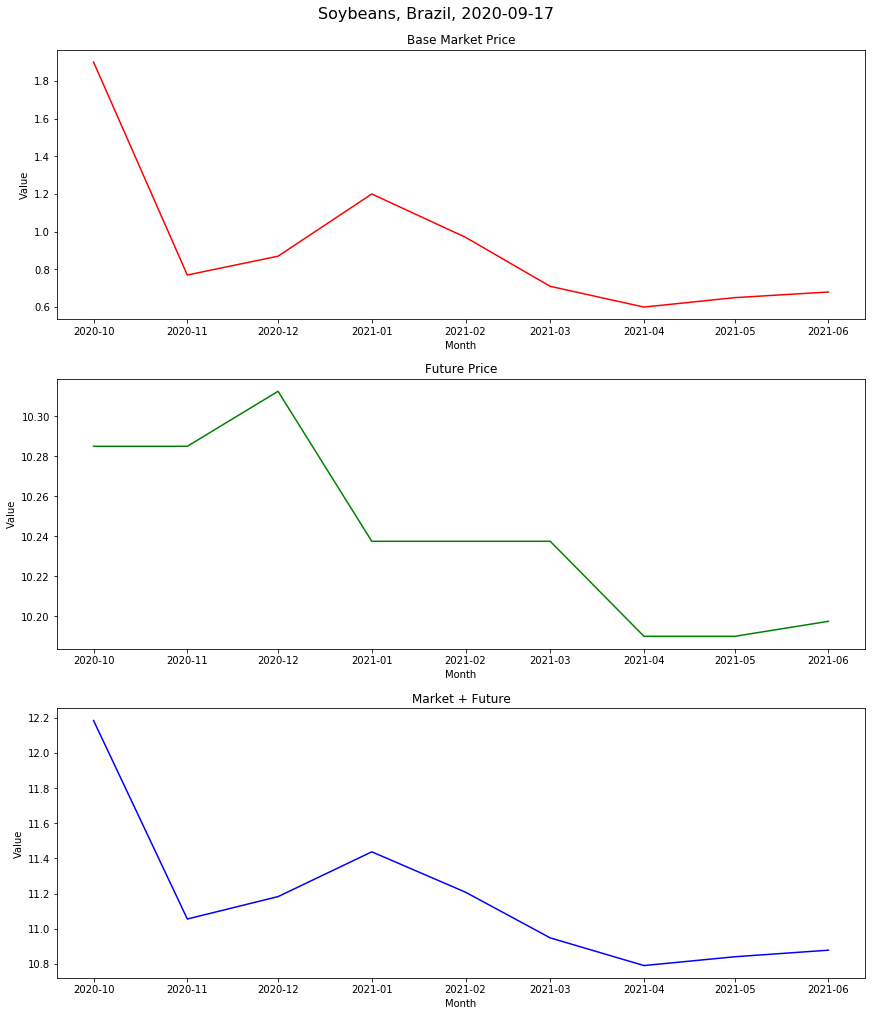

In [12]:
from datetime import datetime
import matplotlib.pyplot as plt

# Select Brazil
bra1 = df[df["ORIGIN_CODE"]=='BRAZIL']
bra1['Base_Future'] = bra1["BASE_MARKET_PRICE"] + bra1["FUTURE_PRICE"]

#
bra1['TRADING_PERIOD'] = pd.to_datetime(bra1['TRADING_PERIOD'], format='%Y%m')
bra1.set_index("TRADING_PERIOD", drop=True, inplace=True)
bra1.drop_duplicates(inplace=True)
bra1 = bra1.sort_values('TRADING_PERIOD')
bra1 = bra1['2020-10-01':'2021-06-01']

fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(12,14))
axs[0].plot(bra1.BASE_MARKET_PRICE,'-', color = 'r')
axs[0].set_title('Base Market Price')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Value')
fig.suptitle('Soybeans, Brazil, 2020-09-17', fontsize=16)

axs[1].plot(bra1.FUTURE_PRICE, '-', color = 'g')
axs[1].set_title('Future Price')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Value')

axs[2].plot(bra1.Base_Future, '-', color = 'b')
axs[2].set_title('Market + Future')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Value')
plt.savefig('test1.png')
plt.show()


### Take a look at freight data

In [13]:
#Premium 

cursor = connection.cursor()
dt1 = cursor.execute("""
    select PRICE_DATE, 
    TRADING_PERIOD, 
    COMMODITY_GROUP_CODE,
    COMMODITY_CODE,
    ORIGIN_CODE,
    MARKET_CODE,
    RESPONSIBLE_SITE_CODE,
    MARKET_PRICE_GROUP_NAME,
    FLAT_PREMIUM_IND,
    RIC_CODE,
    PRICE_UNIT_CODE,
    CURRENCY_CODE,
    BASE_MARKET_PRICE,
    MARKET_PRICE,
    FUTURE_PRICE
    
    from DST_V_MARKET_PRICE_PHS 
    where COMMODITY_GROUP_CODE = 'FREIGHT' 
    and ORIGIN_CODE = 'BRAZIL'
    and PRICE_DATE = TO_DATE('2020-09-10','YYYY-MM-DD')
    """)
df = pd.DataFrame(dt1)
df.columns = [column[0] for column in cursor.description]
df.head(3)

,PRICE_DATE,TRADING_PERIOD,COMMODITY_GROUP_CODE,COMMODITY_CODE,ORIGIN_CODE,MARKET_CODE,RESPONSIBLE_SITE_CODE,MARKET_PRICE_GROUP_NAME,FLAT_PREMIUM_IND,RIC_CODE,PRICE_UNIT_CODE,CURRENCY_CODE,BASE_MARKET_PRICE,MARKET_PRICE,FUTURE_PRICE
0,2020-09-10,202201,FREIGHT,FREIGHT SOYABEAN,BRAZIL,BRAZIL,ROTTERDAM,Freight Freight Soyabean Cif Brazil World,F,None,MT,USD,None,None,None
1,2020-09-10,202111,FREIGHT,FREIGHT SOYABEAN,BRAZIL,BRAZIL,ROTTERDAM,Freight Freight Soyabean Cif Brazil World,F,None,MT,USD,None,None,None
2,2020-09-10,202112,FREIGHT,FREIGHT SOYABEAN,BRAZIL,BRAZIL,ROTTERDAM,Freight Freight Soyabean Cif Brazil World,F,None,MT,USD,None,None,None


### Now, try corn instead of soybeans

In [14]:
#Premium 
cursor = connection.cursor()
dt1 = cursor.execute("""
    select PRICE_DATE, 
    TRADING_PERIOD, 
    COMMODITY_GROUP_CODE,
    COMMODITY_CODE,
    ORIGIN_CODE,
    MARKET_CODE,
    RESPONSIBLE_SITE_CODE,
    MARKET_PRICE_GROUP_NAME,
    FLAT_PREMIUM_IND,
    RIC_CODE,
    PRICE_UNIT_CODE,
    CURRENCY_CODE,
    BASE_MARKET_PRICE,
    MARKET_PRICE,
    FUTURE_PRICE
    
    from DST_V_MARKET_PRICE_PHS 
    where COMMODITY_GROUP_CODE = 'SOYABEANS' 
    and MARKET_CODE = 'PARANAGUA'
    and ORIGIN_CODE = 'BRAZIL'
    and FLAT_PREMIUM_IND = 'P' 
    and COMMODITY_CODE = 'BRA SBNS'
    and TRADING_PERIOD = '202003'
    """)
df = pd.DataFrame(dt1)
df.columns = [column[0] for column in cursor.description]
df.head(5)

,PRICE_DATE,TRADING_PERIOD,COMMODITY_GROUP_CODE,COMMODITY_CODE,ORIGIN_CODE,MARKET_CODE,RESPONSIBLE_SITE_CODE,MARKET_PRICE_GROUP_NAME,FLAT_PREMIUM_IND,RIC_CODE,PRICE_UNIT_CODE,CURRENCY_CODE,BASE_MARKET_PRICE,MARKET_PRICE,FUTURE_PRICE
0,2020-03-10,202003,SOYABEANS,BRA SBNS,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SH0,BUSHEL,USD,0.38,0.38,8.7300
1,2020-03-11,202003,SOYABEANS,BRA SBNS,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SH0,BUSHEL,USD,0.46,0.46,8.6775
2,2020-03-18,202003,SOYABEANS,BRA SBNS,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SH0,BUSHEL,USD,0.64,0.64,NaN
3,2020-03-19,202003,SOYABEANS,BRA SBNS,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SH0,BUSHEL,USD,0.64,0.64,NaN
4,2020-03-30,202003,SOYABEANS,BRA SBNS,BRAZIL,PARANAGUA,ROTTERDAM,Soyabeans Bra Sbns Yel Fob Paranagua World,P,SH0,BUSHEL,USD,0.55,0.55,NaN


In [15]:
#Premium 
cursor = connection.cursor()
dt1 = cursor.execute("""
    select PRICE_DATE, 
    TRADING_PERIOD, 
    COMMODITY_GROUP_CODE,
    COMMODITY_CODE,
    ORIGIN_CODE,
    MARKET_CODE,
    RESPONSIBLE_SITE_CODE,
    MARKET_PRICE_GROUP_NAME,
    FLAT_PREMIUM_IND,
    RIC_CODE,
    PRICE_UNIT_CODE,
    CURRENCY_CODE,
    BASE_MARKET_PRICE,
    MARKET_PRICE,
    FUTURE_PRICE
    
    from DST_V_MARKET_PRICE_PHS 
    where COMMODITY_GROUP_CODE = 'CORN'  /*Set Commodity*/
    and MARKET_CODE = 'PARANAGUA'
    and ORIGIN_CODE = 'BRAZIL'
    and FLAT_PREMIUM_IND = 'P' 
    and TRADING_PERIOD = '202003'
    """)
df = pd.DataFrame(dt1)
df.columns = [column[0] for column in cursor.description]
df.head(5)

,PRICE_DATE,TRADING_PERIOD,COMMODITY_GROUP_CODE,COMMODITY_CODE,ORIGIN_CODE,MARKET_CODE,RESPONSIBLE_SITE_CODE,MARKET_PRICE_GROUP_NAME,FLAT_PREMIUM_IND,RIC_CODE,PRICE_UNIT_CODE,CURRENCY_CODE,BASE_MARKET_PRICE,MARKET_PRICE,FUTURE_PRICE
0,2020-01-16,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.82,0.82,3.7550
1,2020-01-10,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.82,0.82,3.8575
2,2020-01-23,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.82,0.82,3.9375
3,2020-01-29,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.82,0.82,3.8425
4,2020-01-09,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.82,0.82,3.8325


### Now, for one Trading_Period, find all Price_Dates

In [16]:
df1 = df.set_index("PRICE_DATE")
df1.tail()

,TRADING_PERIOD,COMMODITY_GROUP_CODE,COMMODITY_CODE,ORIGIN_CODE,MARKET_CODE,RESPONSIBLE_SITE_CODE,MARKET_PRICE_GROUP_NAME,FLAT_PREMIUM_IND,RIC_CODE,PRICE_UNIT_CODE,CURRENCY_CODE,BASE_MARKET_PRICE,MARKET_PRICE,FUTURE_PRICE
PRICE_DATE,,,,,,,,,,,,,,
2019-07-05,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.52,0.52,4.4900
2018-12-31,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.33,0.33,4.0700
2019-07-24,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.46,0.46,4.3975
2019-12-11,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.82,0.82,3.7125
2020-02-13,202003,CORN,BRAZ CORN,BRAZIL,PARANAGUA,ROTTERDAM,Corn Braz Corn Fob Santos World,P,CH0,BUSHEL,USD,0.82,0.82,3.7950


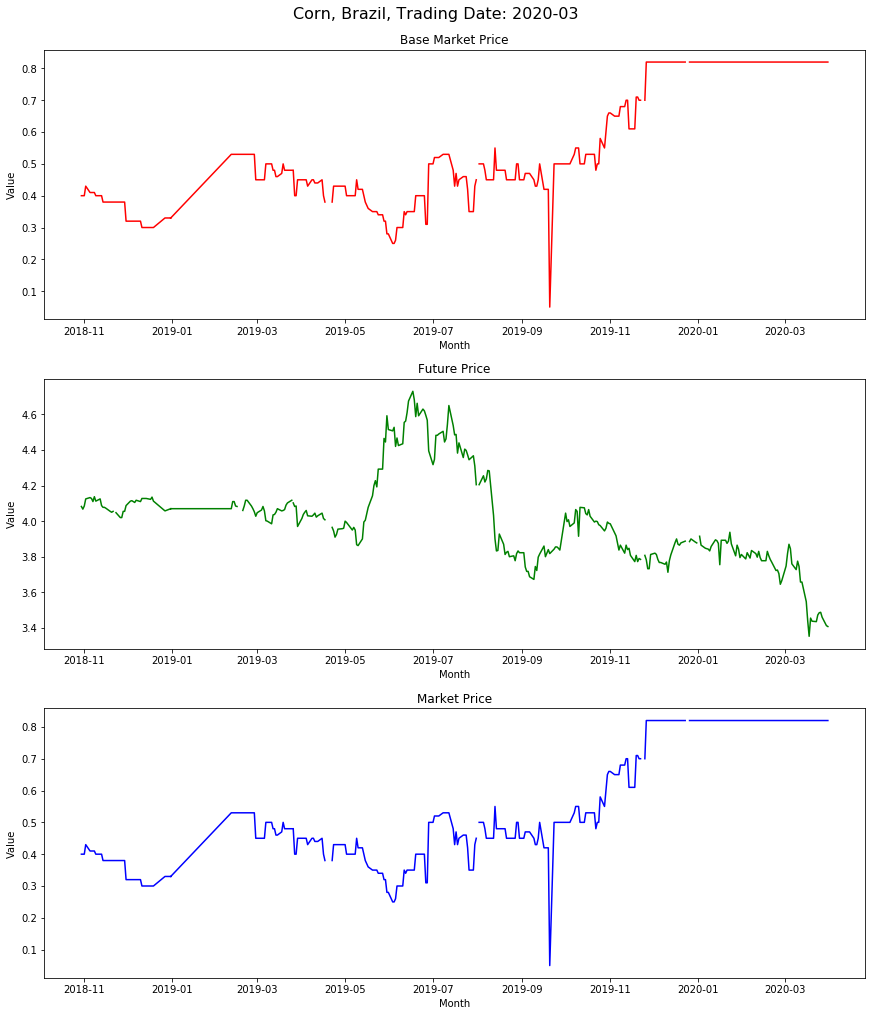

In [17]:
df1.sort_index(inplace=True)

fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(12,14))
axs[0].plot(df1.BASE_MARKET_PRICE,'-', color = 'r')
axs[0].set_title('Base Market Price')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Value')
fig.suptitle('Corn, Brazil, Trading Date: 2020-03', fontsize=16)

axs[1].plot(df1.FUTURE_PRICE, '-', color = 'g')
axs[1].set_title('Future Price')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Value')

axs[2].plot(df1.MARKET_PRICE, '-', color = 'b')
axs[2].set_title('Market Price')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Value')
plt.savefig('test1.png')
plt.show()

### Import csv files and combine features

In [18]:
mealexp1 = 'meal_exports.xlsx'
exp1 = pd.read_excel(mealexp1, sheet_name="MEAL Exports", usecols=[0, 1], parse_dates=True)
prc1 = pd.read_excel(mealexp1, sheet_name="Meal Prices", usecols=[0, 2], parse_dates=True)
exp1 = exp1[:-1]
exp1['Date'] = pd.to_datetime(exp1['DATE'], format= '%Y-%m')
exp1.drop(columns=["DATE"], inplace=True)
exp1.set_index("Date", inplace=True)
prc1.set_index('Date', inplace=True)

df1 = exp1.join(prc1)
df1.columns = ['Exports', 'MonthPrice']
df1.Exports = df1.Exports/3

df1 = df1.loc['2013-01-01':'2021-01-01']
df1.head()

,Exports,MonthPrice
Date,,
2013-01-01,3292.333333,423.1
2013-02-01,2774.000000,435.6
2013-03-01,2894.333333,400.5
2013-04-01,4117.666667,414.5
2013-05-01,4826.333333,425.8


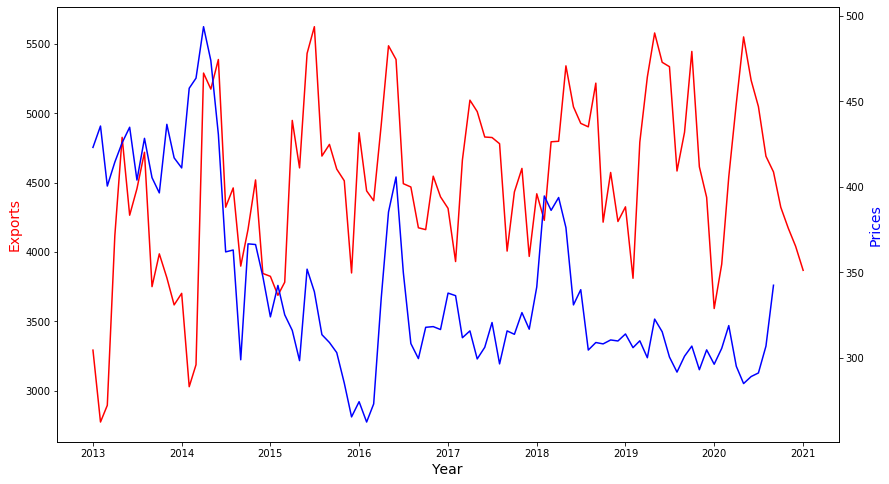

In [19]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(14,8))
# make a plot
ax.plot(df1.index, df1.Exports, color="red")
# set x-axis label
ax.set_xlabel("Year",fontsize=14)
# set y-axis label
ax.set_ylabel("Exports",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df1.index, df1["MonthPrice"],color="blue")
ax2.set_ylabel("Prices",color="blue",fontsize=14)
plt.show()


In [20]:
print('Correlation between Exports and Prices:', df1['Exports'].corr(df1['MonthPrice']))

Correlation between Exports and Prices: -0.2533358535241607
